In [1]:
"""
source: https://github.com/LauraGomezNavarro/OceanParcels_Lyapunov/blob/main/code/FTLE_func_test.py
Author: Laura Gomez Navarro
"""
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import xarray as xr
import numpy.linalg as LA
from datetime import timedelta

from matplotlib import pyplot, colors



In [3]:
year = 2015
dates = 'Oct1-16'
home_folder = '/nethome/manra003/analysis/dispersion/'
output_folder = home_folder+ 'outputs/ftle/'

ds = np.load(output_folder + 'FTLE_BU_0625_{0}_{1}.npz'.format(dates, year))
FTLE_f = ds['FTLE_f']
print(np.nanmin(FTLE_f), np.nanmax(FTLE_f))

coords = np.load(home_folder + 'Benguela_0pt0625_FULLm_release_points.npz')

-0.06803999822148546 0.3721552085608528


In [4]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,0,:,:]

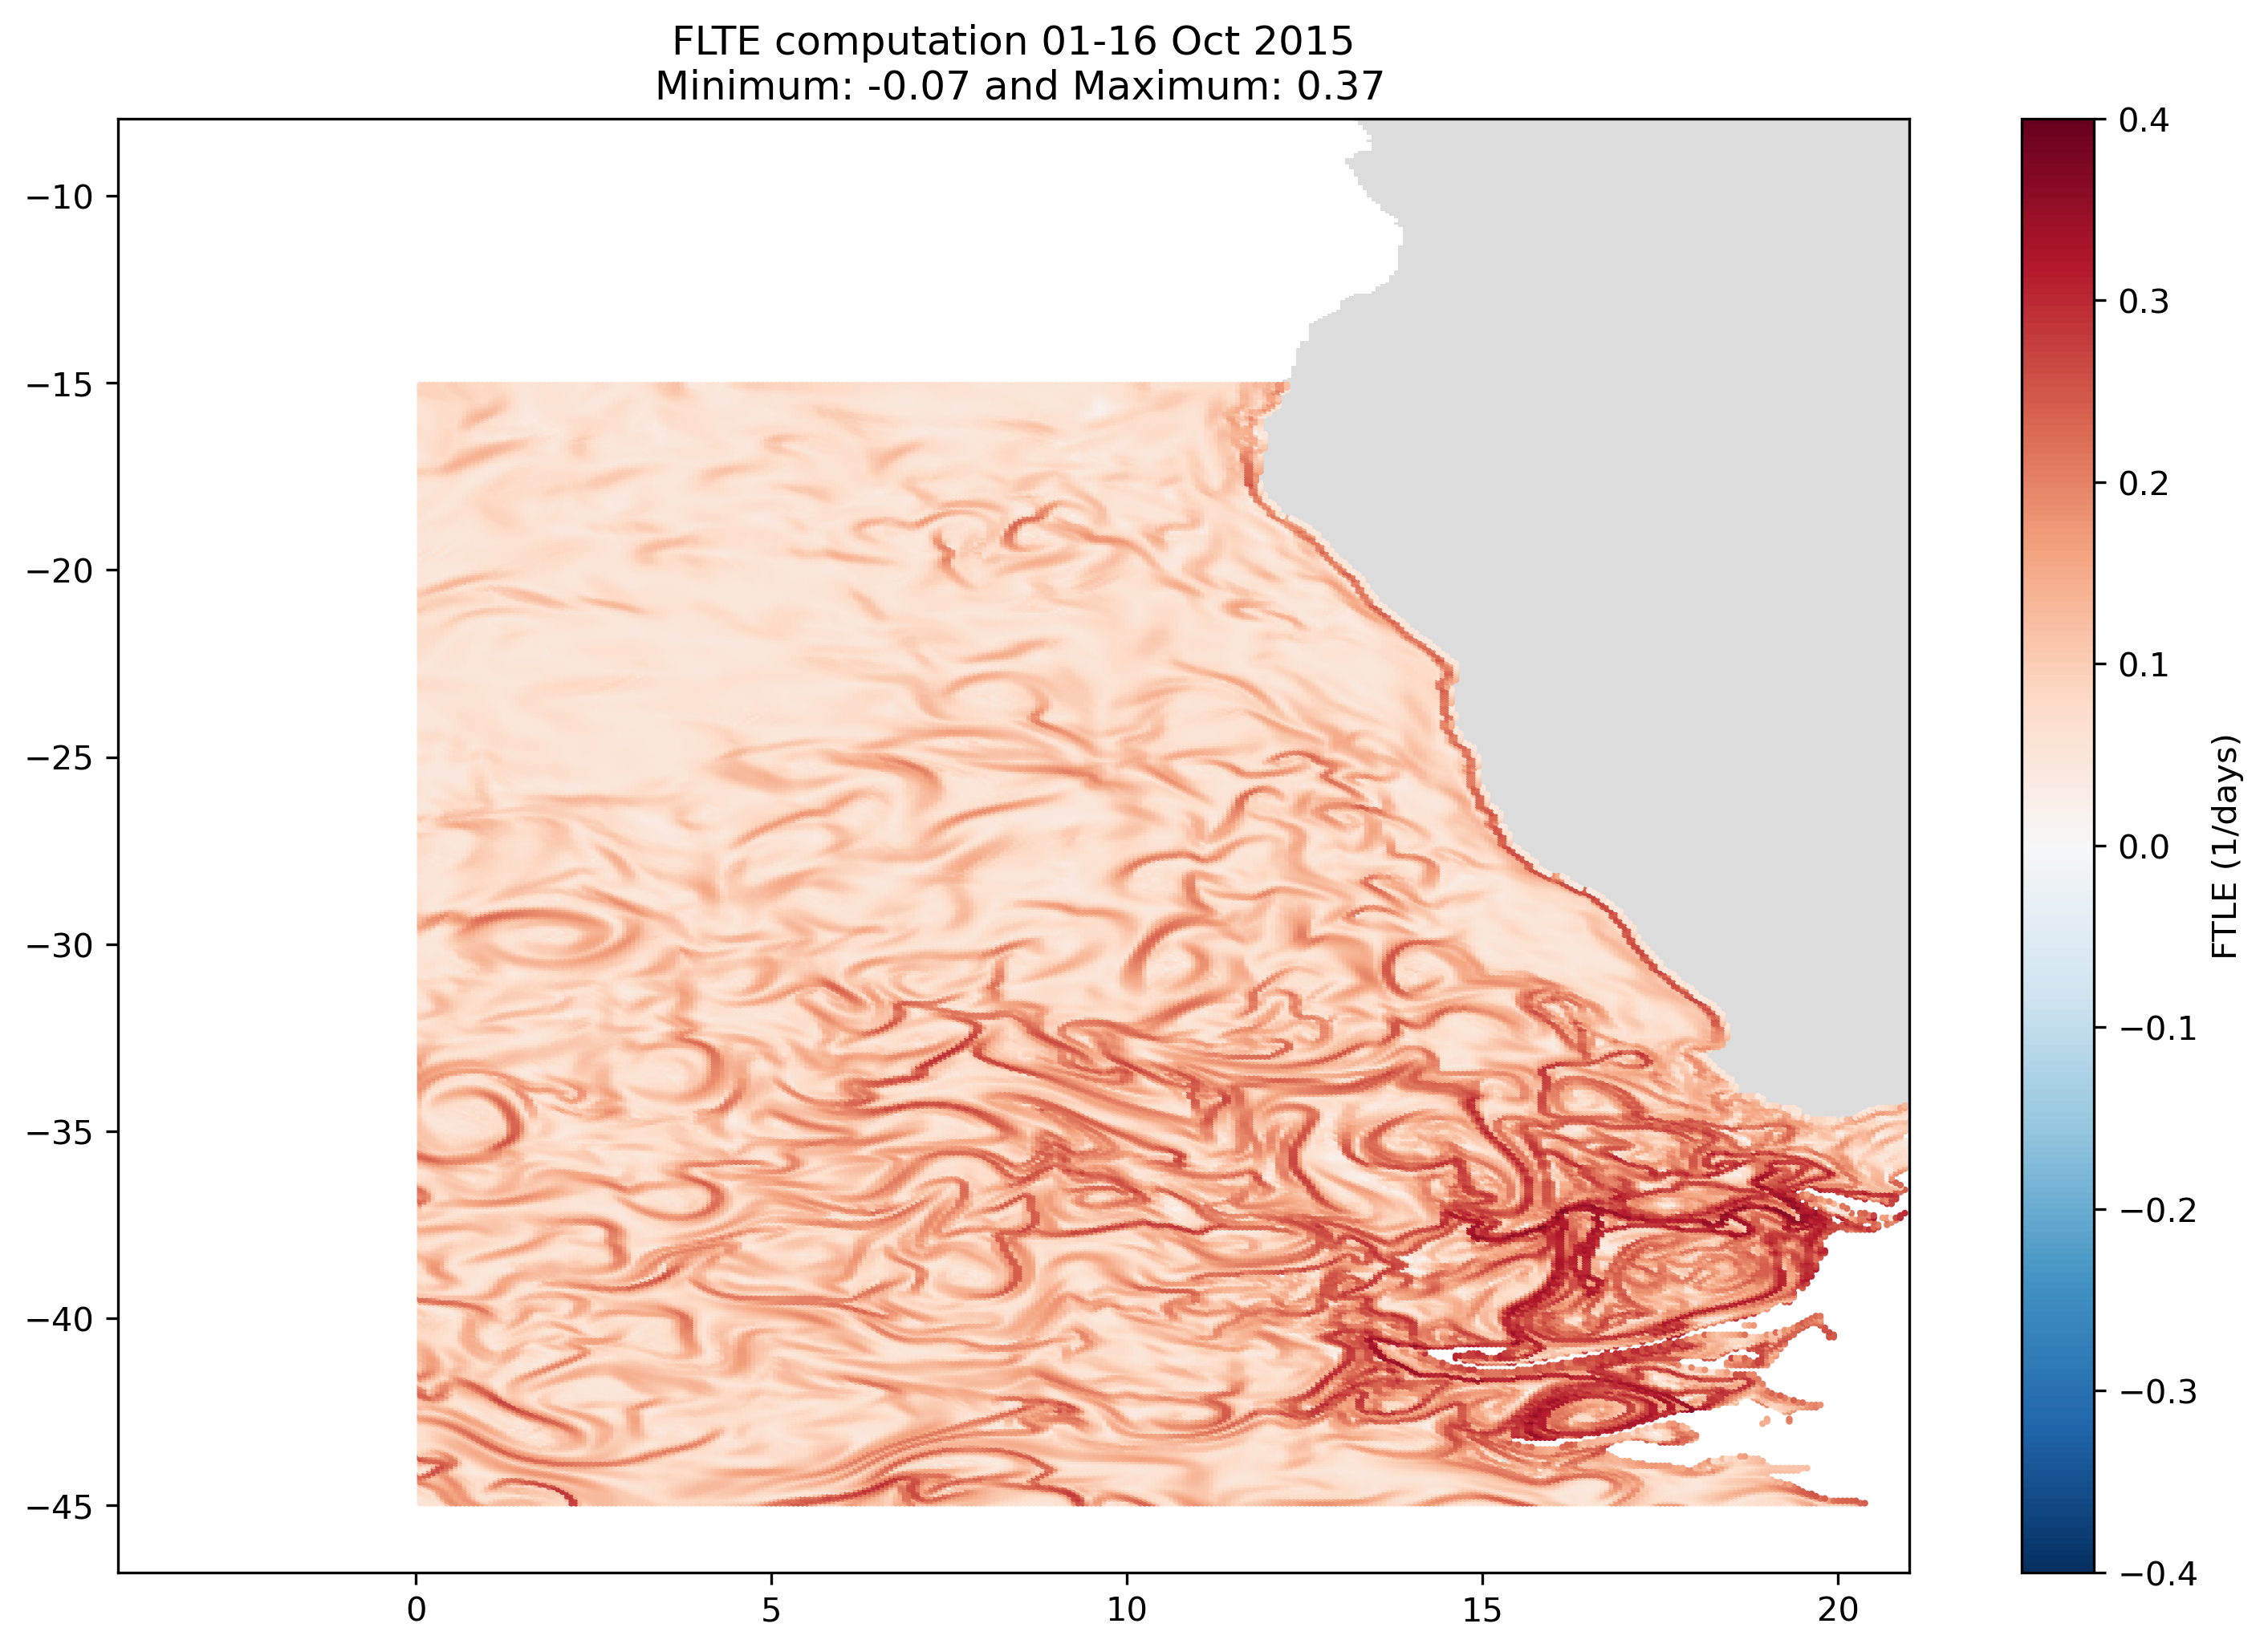

In [5]:
fig = pyplot.figure(figsize=(12,8), dpi=300)
ax = pyplot.axes()
colormap = colors.ListedColormap(['gainsboro', 'white'])
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 1250:1750, 1500:], cmap=colormap)

pyplot.scatter(coords['Longitude'], coords['Latitude'], c=FTLE_f, cmap='RdBu_r', s=1)
pyplot.title('FLTE computation 01-16 Oct {1}\n Minimum: {2} and Maximum: {3}'.format(dates, year, np.round(np.nanmin(FTLE_f),2), np.round(np.nanmax(FTLE_f),2)))
cbar = pyplot.colorbar()
cbar.set_label("FTLE (1/days)")
pyplot.clim(-0.4, 0.4)

pyplot.savefig(output_folder + "Benguela_0pt0625_FULLm_{0}_{1}.jpeg".format(dates, year))


In [12]:
def ftle_brunton_2009(J, Td):  # http://cwrowley.princeton.edu/papers/BruntonChaos09.pdf
    D = np.dot(np.transpose(J), J)  # Cauchy–Green strain tensor
    lamda = LA.eigvals(D)
    lam_max = max(lamda)
    ftle = (1 / Td) * np.log(np.sqrt(lam_max))
    return ftle


def dist_pairs_km(inlon1, inlon2, inlat1, inlat2):
    """
    source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

    """
    # approximate radius of earth in km
    R = 6373.0

    lon1 = radians(inlon1)
    lat1 = radians(inlat1)
    lon2 = radians(inlon2)
    lat2 = radians(inlat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance



In [13]:
home_folder = '/nethome/manra003/analysis/dispersion/'

year = 2015
# dates = 'Aug1-16'
# dates = 'Aug16-31'
# dates = 'Sep01-16'
dates = 'Dec1-Dec16'

ds = xr.open_zarr(home_folder + 'test/Benguela_0pt0625_FULLm_Dec01-30_2015.zarr')

output_dt = timedelta(hours=6)  # from the simulation

Td = 15
out_index = Td * 4
time_range = np.arange(np.nanmin(ds['time'].values),
                       np.nanmax(ds['time'].values) + np.timedelta64(output_dt),
                       output_dt)
print(time_range[0], time_range[out_index])


2015-12-01T12:00:00.000000000 2015-12-16T12:00:00.000000000


In [7]:
ds1

<xarray.Dataset>
Dimensions:     (trajectory: 162097, obs: 121)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119 120
  * trajectory  (trajectory) int64 0 1 2 3 4 ... 162093 162094 162095 162096
Data variables:
    lat         (trajectory, obs) float64 dask.array<chunksize=(162097, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 dask.array<chunksize=(162097, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(162097, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 dask.array<chunksize=(162097, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.4.1-112-g182e3085

In [20]:
# step = 0.25
# left_lon = 0
# right_lon = 20
# top_lat = -10
# bottom_lat = -40

# # add step later - also in the released particles
# lons_list = np.arange(left_lon, right_lon + step, step)
# lats_list = np.arange(bottom_lat, top_lat + step, step)

# grid_lons, grid_lats = np.meshgrid(lons_list, lats_list)


In [18]:
step = 0.0625
coords = np.load('/nethome/manra003/analysis/dispersion/Benguela_0pt0625_FULLm_release_points.npz')

# grid_lons, grid_lats = np.meshgrid(coords['Longitude'], coords['Latitude'])
grid_lons, grid_lats=ds['lon'][:, 0], ds['lat'][:, 0]

In [17]:
ds['lon'][:, 0].shape, grid_lons.shape[0], grid_lons.shape[1]

((7639,), 121, 81)

In [19]:
coords['Longitude'].shape

(481, 337)

In [20]:
# initial position
x0 = np.reshape(ds['lon'][:, 0].data, (coords['Longitude'].shape[0], coords['Longitude'].shape[1]))
y0 = np.reshape(ds['lat'][:, 0].data, (coords['Longitude'].shape[0], coords['Longitude'].shape[1]))

# final position

x1 = np.reshape(ds['lon'][:, out_index].data, (coords['Longitude'].shape[0], coords['Longitude'].shape[1]))
y1 = np.reshape(ds['lat'][:, out_index].data, (coords['Longitude'].shape[0], coords['Longitude'].shape[1]))


In [21]:
# # initial position
# x0 = np.reshape(ds['lon'][:, 0].data, (grid_lons.shape[0], grid_lons.shape[1]))
# y0 = np.reshape(ds['lat'][:, 0].data, (grid_lats.shape[0], grid_lats.shape[1]))

# # final position

# x1 = np.reshape(ds['lon'][:, out_index].data, (grid_lons.shape[0], grid_lons.shape[1]))
# y1 = np.reshape(ds['lat'][:, out_index].data, (grid_lats.shape[0], grid_lats.shape[1]))

H = x0.shape[0]
L = x1.shape[1]

FTLE_f = np.ones_like(np.asarray(x0))
FTLE_f[:,:] = np.NaN

J = np.empty([2, 2], float) * np.nan

type(FTLE_f), type(J)


(numpy.ndarray, numpy.ndarray)

In [22]:
# 1, H-1 --> to ignore bordersx for now
for i in range(1, H - 1):  # 0, H-2
    for j in range(1, L - 1):  # 0, L-2
        J[0][0] = dist_pairs_km(x1[i, j], x1[i - 1, j], y1[i, j], y1[i - 1, j]) / dist_pairs_km(x0[i, j], x0[i - 1, j],
                                                                                                y0[i, j], y0[i - 1, j])
        J[0][1] = dist_pairs_km(x1[i, j], x1[i, j - 1], y1[i, j], y1[i, j - 1]) / dist_pairs_km(x0[i, j], x0[i, j - 1],
                                                                                                y0[i, j], y0[i, j - 1])
        J[1][0] = dist_pairs_km(x1[i, j], x1[i, j + 1], y1[i, j], y1[i, j + 1]) / dist_pairs_km(x0[i, j], x0[i, j + 1],
                                                                                                y0[i, j], y0[i, j + 1])
        J[1][1] = dist_pairs_km(x1[i, j], x1[i + 1, j], y1[i, j], y1[i + 1, j]) / dist_pairs_km(x0[i, j], x0[i + 1, j],
                                                                                                y0[i, j], y0[i + 1, j])

        if np.isnan(J).any():
            continue
        elif np.all((J == 1.0)):  # identify all land points- static points: No dispersion?
            continue
        else:
            f_value = ftle_brunton_2009(J, Td)
            FTLE_f[i][j] = f_value
print(np.nanmin(FTLE_f), np.nanmax(FTLE_f))

KeyboardInterrupt: 

In [ ]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,0,:,:]

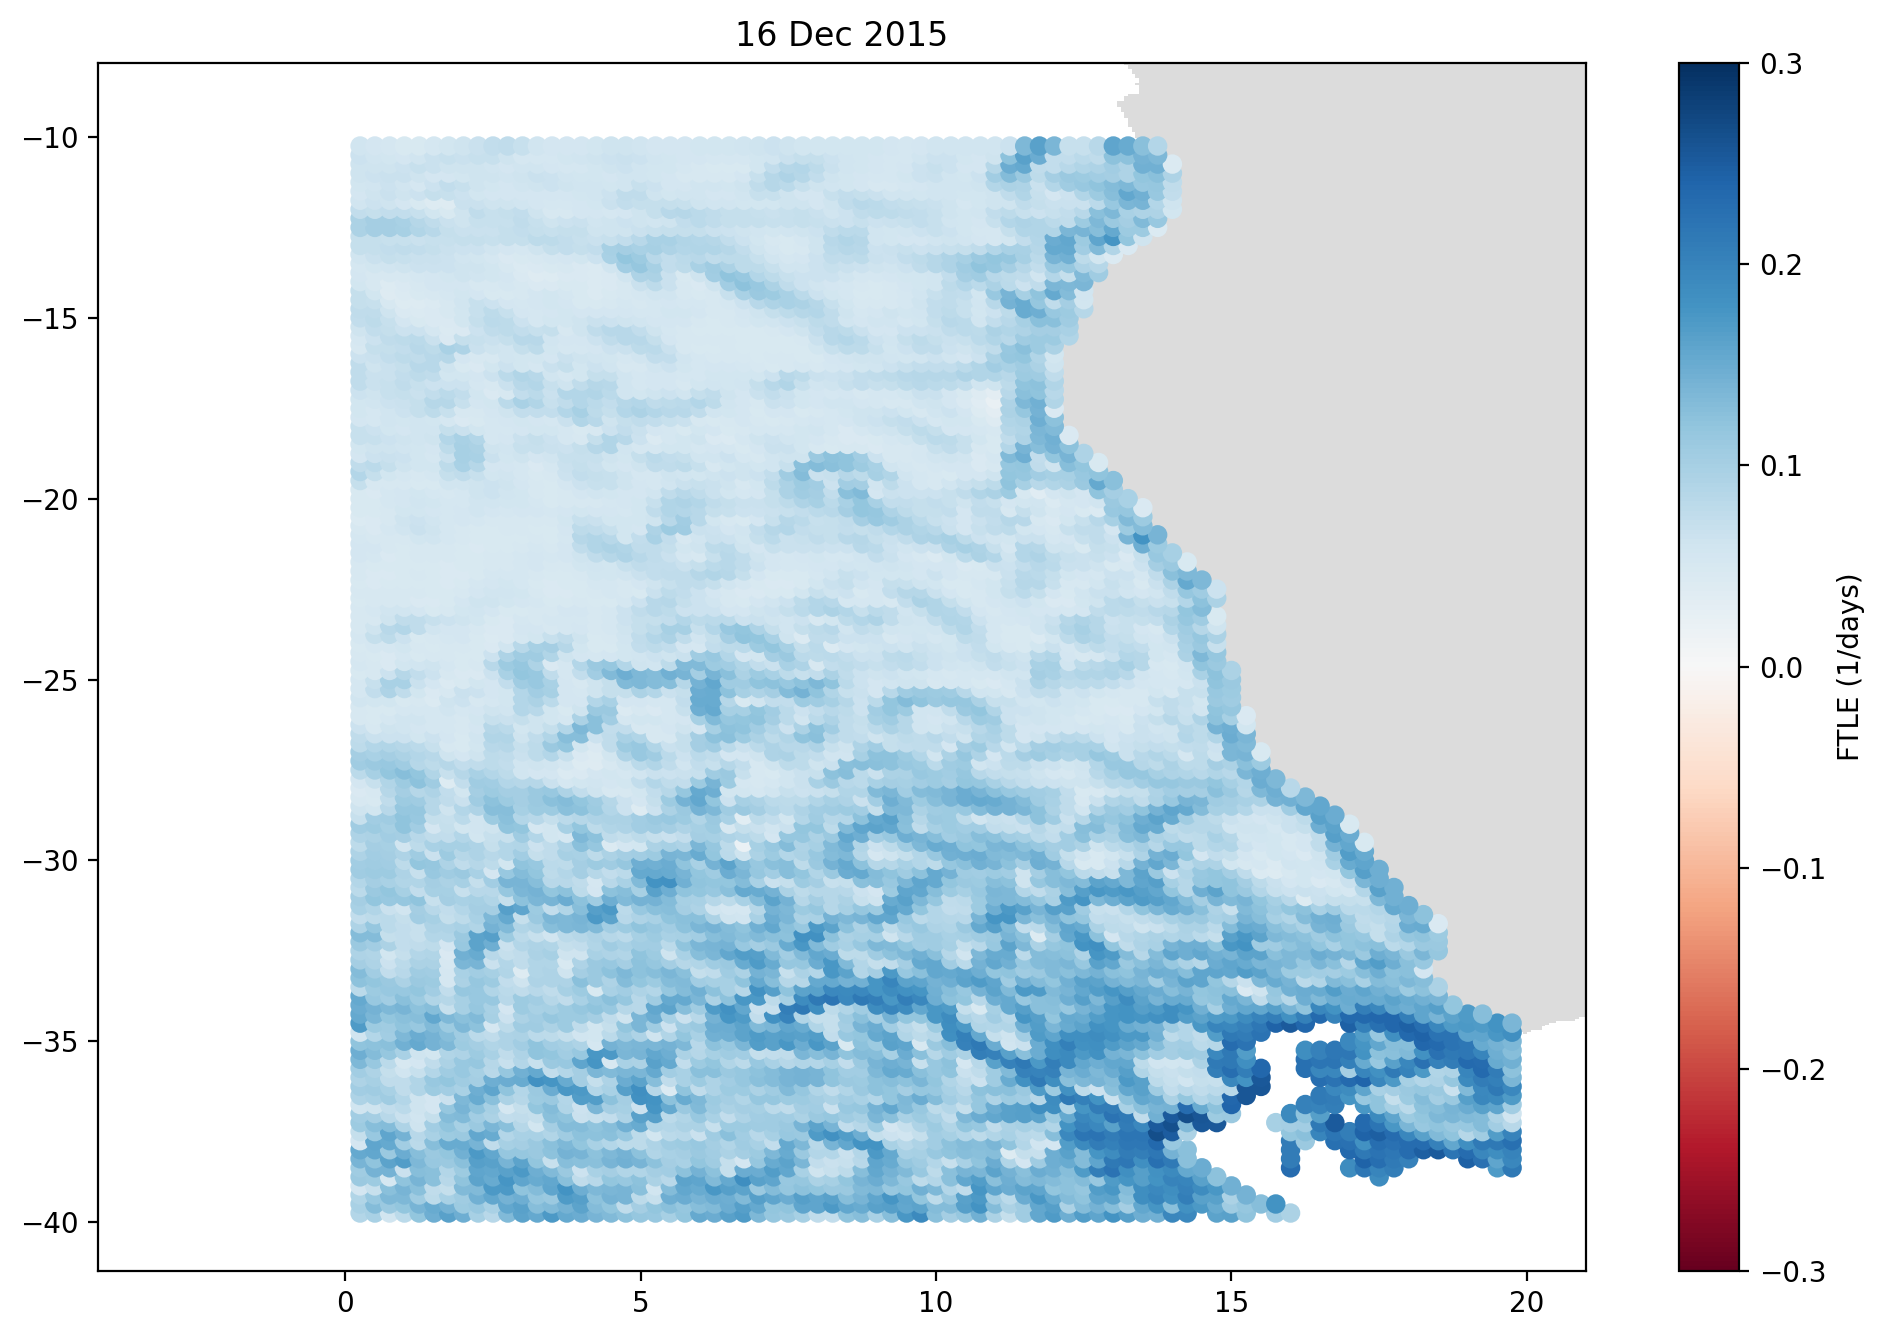

In [59]:

# we need to coordinates file to access the corner points - glamf/gphif


fig = pyplot.figure(figsize=(12,8), dpi=200)
ax = pyplot.axes()
colormap = colors.ListedColormap(['gainsboro', 'white'])
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 1250:1750, 1500:], cmap=colormap)

pyplot.scatter(grid_lons, grid_lats, c=FTLE_f, cmap='RdBu')
pyplot.title('16 Dec {1}'.format(dates, 2015))
cbar = pyplot.colorbar()
cbar.set_label("FTLE (1/days)")
pyplot.clim(-0.3, 0.3)

pyplot.show()


In [3]:
coords = np.load('/nethome/manra003/analysis/dispersion/Benguela_0pt0625_FULLm_release_points.npz')


In [11]:
coords['Longitude']

array([ 0.    ,  0.0625,  0.125 , ..., 20.875 , 20.9375, 21.    ])